In [1]:
import os
import pandas as pd
from tqdm import tqdm
import vqa_logger 
import logging
from pathlib import Path
import datetime
from common import DAL
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
logger = logging.getLogger(__name__)

In [2]:
df_models = DAL.get_models_data_frame()
df_models = df_models[['class_strategy', 'parameter_count', 'loss_function', 'trainable_parameter_count','activation', 'notes',]]
# 'model_location',
df_scores = DAL.get_partial_scores_data_frame()
df_question_categories = DAL.get_question_categories_data_frame()
df_evaluation_types = DAL.get_evaluation_types_data_frame()

In [3]:
# df_models.tail()

In [4]:
# df_scores.tail()

In [5]:
# df_question_categories

In [6]:
# df_evaluation_types

In [7]:
df = df_models.join(df_scores, how='inner')\
    .join(df_question_categories, on='question_category_id')\
    .join(df_evaluation_types, on='evaluation_type')\
    .sort_index(ascending=False)


df=df[['Category', 'name', 'score','class_strategy',  'loss_function','activation', 'parameter_count','trainable_parameter_count', 'notes']]
df.head()


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes
203,Abnormality,wbss,0.094783,answers,categorical_crossentropy,softmax,20107947,83295,"post_concat_dense_units: (8, 7, 6);\nOptimizer..."
203,Abnormality,bleu,0.046267,answers,categorical_crossentropy,softmax,20107947,83295,"post_concat_dense_units: (8, 7, 6);\nOptimizer..."
203,Abnormality,strict_accuracy,0.020964,answers,categorical_crossentropy,softmax,20107947,83295,"post_concat_dense_units: (8, 7, 6);\nOptimizer..."
202,Abnormality,wbss,0.079517,answers,categorical_crossentropy,softmax,20111052,86396,"post_concat_dense_units: (8,);\nOptimizer: RMS..."
202,Abnormality,bleu,0.032323,answers,categorical_crossentropy,softmax,20111052,86396,"post_concat_dense_units: (8,);\nOptimizer: RMS..."


### Get data from notes:

In [8]:
new_columns_data = \
{'post_concat_dense_units': None,
'Optimizer': None,
# 'loss': None,
'activation': None,
'prediction ': None,
'lstm_units': None,
'batch_size': None,
'epochs': None,
'class weights': False,
'Inputs Attention': False}

In [9]:
def note_to_lines(raw):
    n = raw
    for c in [';']:
        n = n.replace(c, '')
    lines = (l.strip() for l in n.split('\n'))
    lines = [l for l in lines if ': ' in l]
    return lines


raw = df.notes.values[0]
lines = note_to_lines(raw)
# print('\n'.join(lines))

def get_data_from_lines(lines, col_name):
    default_val = new_columns_data[col_name]
    relevant_lines = [l for l in lines if col_name in l]
    assert len(relevant_lines) <=1
    if len(relevant_lines) == 0:
        data = default_val
    else:
        line = relevant_lines[0]
        data_str = line.split()[-1]
        try:
            data = eval(data_str)            
        except:
            data = data_str
        
    return data
# print('-'*10)        
# for col in new_columns_data:  
#     data = get_data_from_lines(lines, col)
#     print(f'{col}: {data}')


In [10]:
def notes_to_data(notes, col_name):
    lines =note_to_lines(notes)
    data = get_data_from_lines(lines, col_name)
    return data

for col in new_columns_data:  
    data = notes_to_data(raw, col)
    print(f'{col}: {data}')

post_concat_dense_units: 6)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 128
batch_size: 32
epochs: 3
class weights: False
Inputs Attention: False


In [11]:
for col in new_columns_data:  
    df[col.replace(' ', '_')] = df.notes.apply(lambda notes: notes_to_data(notes, col))    


In [12]:
print(df.Category.drop_duplicates().values)
print(df.name.drop_duplicates().values)

['Abnormality' 'Modality' 'Organ' 'Plane' 'Abnormality_yes_no']
['wbss' 'bleu' 'strict_accuracy']


## Plot results

In [13]:
cmaps = [c for c in dir(plt.cm) if not c.startswith('_')] 
try:
    i += 1
except:
    i = 0

cmap = cmaps[i]
# cmap = "Blues"
# cmap = plt.cm.jet
# cmap ='Accent'
cmap = 'Paired'

In [14]:
category = 'Abnormality'
evaluation = 'bleu'
cdf = df[(df.Category==category) & (df.name==evaluation)]
print( cdf.columns)
cdf.sample(5)

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention'],
      dtype='object')


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes,post_concat_dense_units,Optimizer,prediction_,lstm_units,batch_size,epochs,class_weights,Inputs_Attention
145,Abnormality,bleu,0.054370,answers,cosine_proximity,sigmoid,20093301,59685,"post_concat_dense_units: (7, 9, 8);\nOptimizer...",8),RMSprop,answers,0.0,32.0,NaN,False,False
41,Abnormality,bleu,0.022495,words,cosine_proximity,tanh,20160839,127207,post_concat_dense_units: 32;\nOptimizer: Adam\...,32,Adam,words,0.0,64.0,NaN,False,False
70,Abnormality,bleu,0.013232,answers,cosine_proximity,None,20083906,50290,prediction_vector: answers\n question_category...,None,None,None,NaN,NaN,10.0,False,False
28,Abnormality,bleu,0.002702,answers,cosine_proximity,tanh,20062172,37740,post_concat_dense_units: 8;\nOptimizer: Adam\n...,8,Adam,answers,8.0,64.0,NaN,False,False
176,Abnormality,bleu,0.026366,answers,categorical_crossentropy,softmax,20111441,86783,"post_concat_dense_units: (6, 9);\nOptimizer: R...",9),RMSprop,answers,128.0,32.0,3.0,True,False


In [40]:

x_name = 'parameter_count'
y_name = 'trainable_parameter_count'

# x_name = 'epochs'
# y_name = 'batch_size'

x_name = 'prediction_'
y_name = 'score'

sizes_name = 'trainable_parameter_count'
df_plot = cdf[[x_name, y_name, 'notes']]
df_plot.loc[:,sizes_name] = (100*cdf[sizes_name])**10

tips = df_plot.notes



print(cmap)
print(len(cdf))
df_plot.head()

# # create data
# x = df_plot[x_name]#np.random.rand(15)
# y = df_plot[y_name]#x+np.random.rand(15)
# z = df_plot[sizes_name]#x+np.random.rand(15)

c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\vqa\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\vqa\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Paired
164


,prediction_,score,notes,trainable_parameter_count
203,answers,0.046267,"post_concat_dense_units: (8, 7, 6);\nOptimizer...",-6716130288661954560
202,answers,0.032323,"post_concat_dense_units: (8,);\nOptimizer: RMS...",6623230446815674368
201,answers,0.020804,"post_concat_dense_units: (8, 7, 6);\nOptimizer...",4141980420240572416
186,answers,0.035557,"post_concat_dense_units: (8, 7, 6);\nOptimizer...",-6716130288661954560
177,answers,0.031575,"post_concat_dense_units: (8, 6);\nOptimizer: R...",-4925812092436480000


In [41]:
is_categorial = df_plot.dtypes[x_name] == object
is_categorial
# df_plot.dtypes

True

In [42]:
%matplotlib qt  
# wx, gtk, osx, tk #inline
sns.set(style="white", color_codes=True)

sizes=(10, 500)
if is_categorial:
    jitter=0.02
    ax = sns.stripplot(x=x_name, y=y_name, data=cdf, alpha=.3,size=cdf[sizes_name], jitter=jitter, edgecolor='gray', sizes=sizes)# size=z,
else:    
    ax = sns.scatterplot(x=x_name, y=y_name, data=cdf,  hue=x_name, size=sizes_name, palette=cmap, sizes=sizes,  alpha=.3, edgecolor='gray')
    
sns.despine()
 
# Add titles (main and on axis)
plt.xlabel(x_name.replace('_', ' '))
plt.ylabel(y_name.replace('_', ' '))
plt.title(f"'{evaluation}' for '{category}'")
 
# plt.show()


SyntaxError: keyword argument repeated (<ipython-input-42-6fc2e4be5396>, line 8)

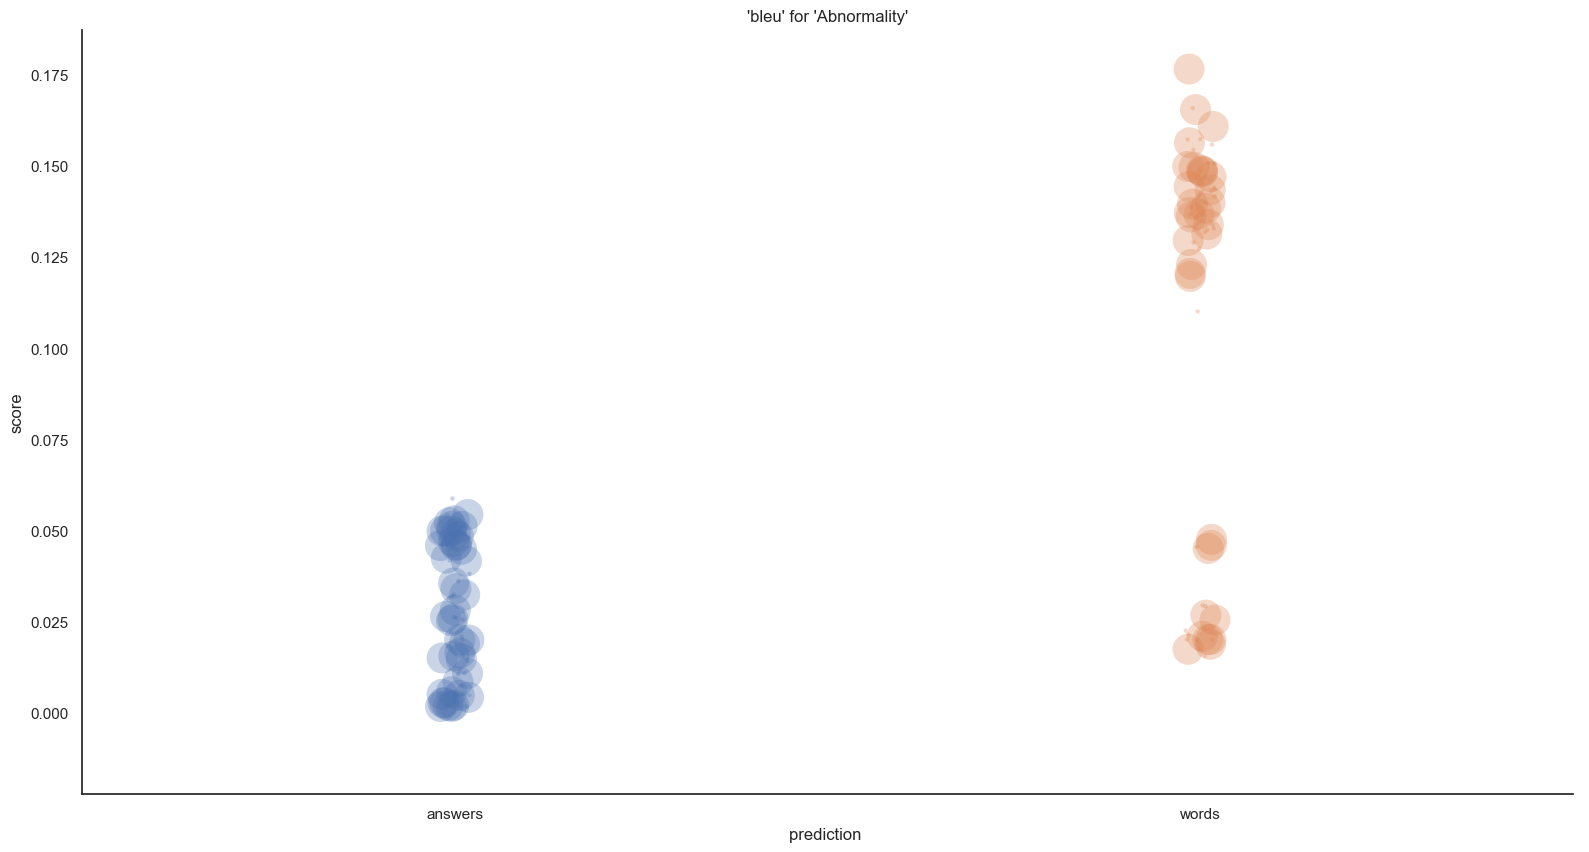

In [30]:
fig = plt.gcf()
plt.rcParams['figure.figsize'] = [20, 10]
fig

In [39]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_in_layout',
 '_init_axis',
 '_label',
 '_layoutbox',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_m

In [32]:
tool_tips = cdf.notes

In [33]:
annot = ax.annotate("", xy=(0, 0), xytext=(-20, 20), textcoords="offset points",bbox=dict(boxstyle="round", fc="w"),arrowprops=dict(arrowstyle="->"))

def update_annot(ind, tt=tool_tips, line_arg=line):
    x, y = line_arg.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text_set = set([tt[n] for n in ind["ind"]])
    text = '\n'.join(text_set)

    # text = "{}, {}".format(" ".join(list(map(str, ind["ind"]))),
    #                        " ".join([tt[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event, ax_arg=ax, line_arg=line, fig_arg=fig):
    vis = annot.get_visible()
    if event.inaxes == ax_arg:
        cont, ind = line_arg.contains(event)
        if cont:
            # print(f'hover: cont - ind: {ind}')
            update_annot(ind)
            annot.set_visible(True)
            fig_arg.canvas.draw_idle()
        else:
            if vis:
                # print(f'hover: NOT cont - ind: {ind}')
                # print('hover: vis - turning off')
                annot.set_visible(False)
                fig_arg.canvas.draw_idle()

def onclick(event, line_arg=line):
    is_vis = annot.get_visible()
    if not is_vis:
        # print('Not visible')
        return
    if not event.dblclick:
        if event.button == 1:
            cont, ind = line_arg.contains(event)
            if cont:
                update_annot(ind)

            txt = annot.get_text()
            print(txt)

        elif event.button == 3:
            # Write to figure
            pass
        else:
            pass  # Do nothing

fig.canvas.mpl_connect("motion_notify_event", hover)
fig.canvas.mpl_connect('button_press_event', onclick)

NameError: name 'line' is not defined